In [3]:
import featurization
import helpers
import model_neighbors

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
import pickle

%reload_ext autoreload
%autoreload 2

In [4]:
test_df = featurization.featurization_for_knn("bike-data/sc-bike-data-ending1109.csv")

Dropping 0 entries where end time was before start time


In [5]:
train_df = featurization.featurization_for_knn("all-sc-bike-data-1101.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Dropping 1 entries where end time was before start time


In [6]:
knn_model = pickle.load(open('knn_pickle.p', "rb"))
scaler = pickle.load(open('scaler.p', "rb"))
X_test_raw = test_df[["lon", "lat", "time_of_day_start", "day_of_week"]]
X_test = scaler.transform(X_test_raw.astype(float))
y_true = test_df['idle_hours']
y_pred = knn_model.predict(X_test)

In [10]:
#avg_rentals_per_bike_per_day
train_df.groupby([train_df['local_time_start'].dt.date, train_df['bike_id']])['idle_time'].count().mean()

3.947141316073355

So bikes are rented, on average, 3.9 times per day. Lets say each rental makes $2. And nighttime hours don't count because bikes are so rarely rented then. This means on average a bike should make about 45 cents an hour for the company.

In [14]:
3.9*2/18

0.43333333333333335

And we'll say, as a ballpark, that the cost of relocating the bike (employee time plus van operation) is $5.

In [15]:
cost_relocate = 5
cost_idle = 0.5

Using the most basic math, you should relocate a bike if you expect it to sit for longer than 10 hours.

In [16]:
relocate_time = cost_relocate/cost_idle
relocate_time

10.0

But what if we apply our exponential distributions of bike distributions to make a profit curve? At what certainty of sitting for 10 hours do we maximize profit?

This tells us the probability that a bike will still be there after our break-even relocate time

In [17]:
prob_bike_is_there = [1-scs.expon(scale=y_pred[i]).cdf(relocate_time) for i in range(len(y_pred))]

In [20]:
labels = (y_true > relocate_time).astype(int)

In [21]:
def standard_confusion_matrix(y_t, y_p):
    y_true = np.array(y_t)
    y_predict = np.array(y_p)
    tp = np.sum((y_true == y_predict) & (y_true == 1))
    fp = np.sum((y_true != y_predict) & (y_true == 0))
    fn = np.sum((y_true != y_predict) & (y_true == 1))
    tn = np.sum((y_true == y_predict) & (y_true == 0))
    return np.array([[tp, fp], [fn, tn]])

A test case on the confusion matrix function

In [22]:
bike_is_there_10 = np.array(prob_bike_is_there) > 0.1
standard_confusion_matrix(labels, bike_is_there_10)

array([[  68,  113],
       [ 134, 1033]])

From the training data, once a bike exceeds the relocate time threshhold (8 hours), it sits, on average, for 15 hours

In [23]:
train_df['idle_hours'].mean()

2.8917501366493643

In [24]:
avg_hours_idle = train_df[train_df['idle_hours']>relocate_time]['idle_hours'].mean()
avg_hours_idle

16.812022556390975

In [25]:
cost_matrix = np.array([[ avg_hours_idle*cost_idle,  -cost_relocate],
                        [ 0,  0]])

In [26]:
def profit_curve(cost_matrix, thresholds, probs, labels):
    '''function profit_curve(cost_benefit, predicted_probs, labels):
    1. Sort instances by their prediction strength (the probabilities)
       - Add 1 at the beginning so that you consider all thresholds
    2. For every instance in decreasing order of probability:
       1. Set the threshold to be the probability
       2. Set everything above the threshold to the positive class
       3. Calculate the confusion matrix
       4. Compute the expected profit:
           - multiply each of the 4 entries in the confusion matrix by
             their associated entry in the cost-benefit matrix
           - sum up these values
           - divide by the total number of data points
    3. Return an array of the profits and their associated thresholds'''
    profits = []
    for t in thresholds:
        cf = standard_confusion_matrix(labels, probs>t)
        profits.append(np.sum(cf*cost_matrix)/np.sum(cf))
#     return (thresholds,profits)  
    return np.array([thresholds,profits]).T

In [27]:
thresholds = np.linspace(0.05, 1)

In [28]:
profit = profit_curve(cost_matrix, thresholds, prob_bike_is_there, labels)

In [29]:
profit[:,1].max()

0.07811614533366053

In [30]:
profit[profit[:,1].argmax(),0]

0.1663265306122449

So if our model shows a 16% probability that a bike will sit for more than 10 hours, we should send someone out to relocate it

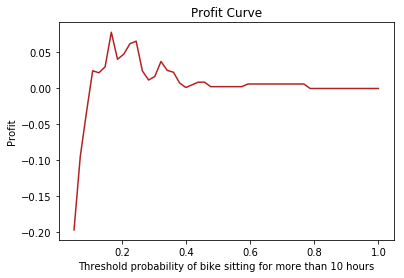

In [139]:
plt.plot(profit[:,0], profit[:,1], c='firebrick')
plt.title("Profit Curve")
plt.xlabel("Threshold probability of bike sitting for more than 10 hours")
plt.ylabel("Profit")
plt.show()

In [137]:
standard_confusion_matrix(labels, np.array(prob_bike_is_there)>0.166)

array([[  50,   64],
       [ 152, 1082]])

In [209]:
def plot_profit_curve(model, cost_benefit, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    probs = model.predict_proba(X_test)[:,1]
    profits = profit_curve(cost_benefit, probs, y_test)[:,1]
    percentages = np.arange(0, 100, 100. / len(profits))
    plt.plot(percentages, profits, label=model.__class__.__name__)
    plt.title("Profit Curve")
    plt.xlabel("Percentage of test instances that we predict to churn")
    plt.ylabel("Profit")

In [33]:
times = test_df[(np.array(prob_bike_is_there) > 0.16) & (labels)].time_of_day_start
times.groupby(times).count()

time_of_day_start
0     2
1     3
4     1
16    4
17    8
18    6
19    5
20    9
21    7
22    3
23    3
Name: time_of_day_start, dtype: int64

In [122]:
departure_99 = [scs.expon(scale=y_pred[i]).ppf(.999) for i in range(len(y_pred))]

In [123]:
exceeded_departure_99 = test_df.idle_hours > departure_99

In [124]:
time_over_99 = test_df.idle_hours[exceeded_departure_99] - np.array(departure_99)[exceeded_departure_99]

In [125]:
time_over_99.describe()

count    75.000000
mean      6.098178
std       4.876384
min       0.044424
25%       1.667290
50%       5.726630
75%       8.830050
max      19.258892
Name: idle_hours, dtype: float64

In [126]:
(time_over_99*0.5 - 5).sum()

-146.31831971433172

In [127]:
(test_df.next_action[exceeded_departure_99].groupby(test_df.next_action).count())/len(test_df[exceeded_departure_99])

next_action
gets_pickedup_charged    0.053333
gets_relocated           0.120000
rented                   0.826667
Name: next_action, dtype: float64

In [128]:
test_df.next_action.groupby(test_df.next_action).count()/len(test_df)

next_action
gets_pickedup_charged    0.051929
gets_relocated           0.113501
rented                   0.834570
Name: next_action, dtype: float64

(array([21., 10.,  8., 13.,  8.,  4.,  3.,  2.,  5.,  1.]),
 array([ 0.04442384,  1.96587065,  3.88731746,  5.80876427,  7.73021107,
         9.65165788, 11.57310469, 13.49455149, 15.4159983 , 17.33744511,
        19.25889192]),
 <a list of 10 Patch objects>)

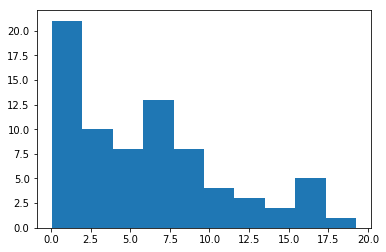

In [132]:
plt.hist(time_over_99, bins = 10)